# Проект: Восстановление золота из руды

## Постановка задачи (кратко)

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

## Подготовка данных

### Первичное изучение данных

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

In [2]:
df_train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
df_test  = pd.read_csv('/datasets/gold_recovery_test_new.csv')
df_full  = pd.read_csv('/datasets/gold_recovery_full_new.csv')

In [3]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


Исходный датасет содержит в себе тренировочный и тестовый. Во всех датасетах присутствуют пропуски.

### Проверка расчетов в датасете

Проверим правильность расчетов эффективности обогащения (recovery) в датасете:

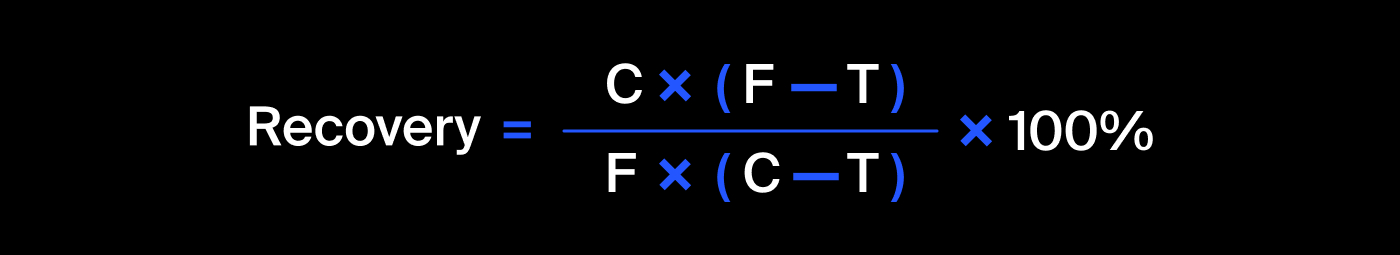

In [4]:
# доля золота в концентрате после флотации/очистки
C = df_full['rougher.output.concentrate_au']
# доля золота в сырье/концентрате до флотации/очистки
F = df_full['rougher.input.feed_au']
# доля золота в отвальных хвостах после флотации/очистки
T = df_full['rougher.output.tail_au']

recovery = (C * (F - T) / (F * (C - T)) * 100)

mean_absolute_error(df_full['rougher.output.recovery'], recovery)

9.874045668302637e-15

Различия в расчетах recovery на уровне 15-го знака после запятой - rougher.output.recovery в исходных данных расчитан верно.

### Анализ отсутствующих в тестовой выборке признаков

Найдем отсутствующие в тестовой выборке признаки:

In [5]:
missing_features = list(df_full.columns.drop(df_test.columns))
missing_features

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

В тестовой выборке отсутствует 34 признака:

По этапам:
- 13 rougher - флотация
- 8 primary_cleaner - первичная очистка
- 4 secondary_cleaner - вторичная очистка
- 9 final - финальные характеристики

По типу параметра:
- 30 output - параметры продукта
- 4 calculation - расчетные характеристики

По названию параметра:
- tail (все 4 этапа) - отвальные хвосты
- concentrate (кроме этапа secondary_cleaner) - концентрат металла
- recovery (целевые признаки) - эффективность обогащения

Значения 2/3 ключевых параметров для расчета recovery в тестовой выборке неизвестны.

### Предобработка данных

Обработаем пропуски. Проверим количество пропусков и логику расположения данных:

In [6]:
# посмотрим на пропуски первых 20 столбцов
df_full.isna().sum().head(20)

date                                        0
final.output.concentrate_ag                 1
final.output.concentrate_pb                 1
final.output.concentrate_sol              211
final.output.concentrate_au                 0
final.output.recovery                       0
final.output.tail_ag                        1
final.output.tail_pb                      101
final.output.tail_sol                       6
final.output.tail_au                        0
primary_cleaner.input.sulfate              24
primary_cleaner.input.depressant           37
primary_cleaner.input.feed_size             0
primary_cleaner.input.xanthate            104
primary_cleaner.output.concentrate_ag       0
primary_cleaner.output.concentrate_pb     116
primary_cleaner.output.concentrate_sol    370
primary_cleaner.output.concentrate_au       0
primary_cleaner.output.tail_ag              4
primary_cleaner.output.tail_pb             21
dtype: int64

In [7]:
# посчитаем все поля с пропусками
df_full.isna().sum().sum()

4481

In [8]:
# проверим хронологичность
df_full['date'].head(10)

0    2016-01-15 00:00:00
1    2016-01-15 01:00:00
2    2016-01-15 02:00:00
3    2016-01-15 03:00:00
4    2016-01-15 04:00:00
5    2016-01-15 05:00:00
6    2016-01-15 06:00:00
7    2016-01-15 07:00:00
8    2016-01-15 08:00:00
9    2016-01-15 09:00:00
Name: date, dtype: object

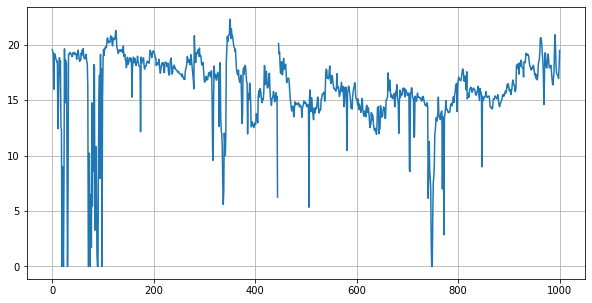

In [9]:
# проверим регулярность на случайном признаке с пропусками
df_full.loc[:1000,'primary_cleaner.output.concentrate_sol'].plot(
    grid=True, figsize=(10,5));

Данные расположены в хронологическом порядке. Параметры со временем меняются плавно, с сохранением тренда. Наблюдаются возможные выбросы. Пропуски можно заполнить историческими значениями:

In [10]:
df = df_full.ffill()
df.isna().sum().sum()

0

## Анализ данных

### Динамика концентрации металлов

Посмотрим, как меняется концентрация металлов на разных стадиях технологического процесса:

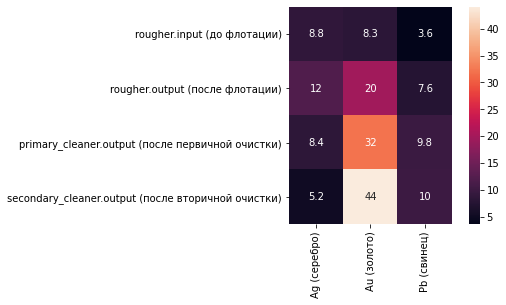

In [11]:
metals = pd.DataFrame({
    'Ag (серебро)' : [df['rougher.input.feed_ag'].mean(),
                        df['rougher.output.concentrate_ag'].mean(),
                        df['primary_cleaner.output.concentrate_ag'].mean(),
                        df['final.output.concentrate_ag'].mean()],
    'Au (золото)' : [df['rougher.input.feed_au'].mean(),
                        df['rougher.output.concentrate_au'].mean(),
                        df['primary_cleaner.output.concentrate_au'].mean(),
                        df['final.output.concentrate_au'].mean()],
    'Pb (свинец)' : [df['rougher.input.feed_pb'].mean(),
                        df['rougher.output.concentrate_pb'].mean(),
                        df['primary_cleaner.output.concentrate_pb'].mean(),
                        df['final.output.concentrate_pb'].mean()]},
    index=['rougher.input (до флотации)', 
           'rougher.output (после флотации)', 
           'primary_cleaner.output (после первичной очистки)', 
           'secondary_cleaner.output (после вторичной очистки)'])

sns.heatmap(metals, annot=True, square=True);

Концентрация золота значительно повышается с каждым этапом обработки. 
<br>Концентрация серебра снижается с каждым этапом после флотации.
<br>Концентрация свинца повышается с каждым этапом до вторичной очистки.

### Распределение размеров гранул сырья

Изучим, как распределен размер гранул сырья в обучающей и тестовой выборках:

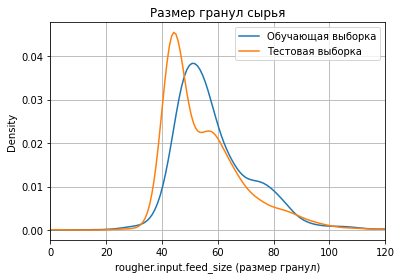

In [12]:
dates_train = df_train['date']
dates_test  = df_test['date']

train_feed_size = df[df['date'].isin(dates_train)]['rougher.input.feed_size']
test_feed_size  = df[df['date'].isin(dates_test)]['rougher.input.feed_size']

train_feed_size.plot(kind='density')
test_feed_size.plot(kind='density')
plt.title('Размер гранул сырья')
plt.xlim(0, 120)
plt.xlabel('rougher.input.feed_size (размер гранул)')
plt.legend(['Обучающая выборка','Тестовая выборка'])
plt.grid();

Проверим гипотезу о равенстве средних размеров гранул сырья в обучающей и тестовой выборках.
<br><b>Нулевая гипотеза:</b> Средний размер гранул сырья в выборках одинаковый
<br><b>Альтернативна гипотеза:</b> Средний размер гранул сырья в выборках различается
<br>Критический уровень значимости: 0.01

In [13]:
results = st.ttest_ind(train_feed_size, test_feed_size, equal_var=False)
results.pvalue

3.134338776805464e-39

P-value значительно меньше критического уровня значимости. Отвергаем нулевую гипотезу. Средний размер гранул сырья в выборках значимо различается. 

Тем не менее, сравнение графиков "на глаз" позволяет сопоставить обучающие и тестовые выборки и принять нулевую гипотезу, так как заказкик гарантирует равенство среднего размера гранул сырья в производстве размеру гранул обучающей выборки.

### Динамика суммарной концентрации металлов

Взглянем, как меняется суммарная концентрация металлов на разных стадиях технологического процесса:

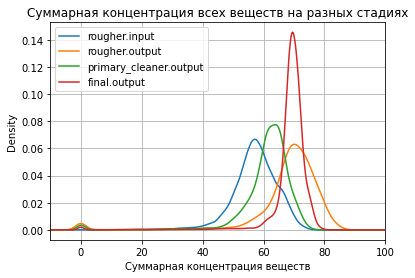

In [14]:
stages = ['rougher.input.feed_',
         'rougher.output.concentrate_',
         'primary_cleaner.output.concentrate_',
         'final.output.concentrate_']
agents = ['ag', 'au', 'pb', 'sol']

concentrations = pd.DataFrame()
for stage in stages:
    concentration = 0
    for agent in agents:
        concentration += df[stage+agent]
    concentrations.insert(concentrations.shape[1], stage, value=concentration)

concentrations.columns = ['rougher.input', 
                          'rougher.output', 
                          'primary_cleaner.output',
                          'final.output']


concentrations.plot(kind='density',)
plt.title('Суммарная концентрация всех веществ на разных стадиях')
plt.xlim(-10, 100)
plt.xlabel('Суммарная концентрация веществ')
plt.grid();

Исследование распределения суммарной концентрации всех веществ на разных стадиях выявило выбросы в данных около ноля. Такие данные аномальны и могут негативно повлиять на обучаемую модель. Избавимся от этих строк:

In [15]:
df = df.drop(concentrations[(concentrations['rougher.input'] <= 5) |
               (concentrations['rougher.output'] <= 5) |
               (concentrations['primary_cleaner.output'] <= 5) |
               (concentrations['final.output'] <= 5) ].index)

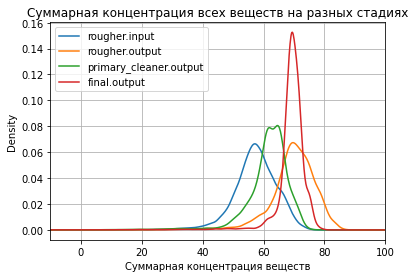

In [16]:
concentrations = pd.DataFrame()
for stage in stages:
    concentration = 0
    for agent in agents:
        concentration += df[stage+agent]
    concentrations.insert(concentrations.shape[1], stage, value=concentration)

concentrations.columns = ['rougher.input', 
                          'rougher.output', 
                          'primary_cleaner.output',
                          'final.output']


concentrations.plot(kind='density',)
plt.title('Суммарная концентрация всех веществ на разных стадиях')
plt.xlim(-10, 100)
plt.xlabel('Суммарная концентрация веществ')
plt.grid();

От выбросов в районе нуля избавились.

## Модель

### Метрика sMAPE

Напишем функцию расчета итоговой кастомной метрики sMAPE:

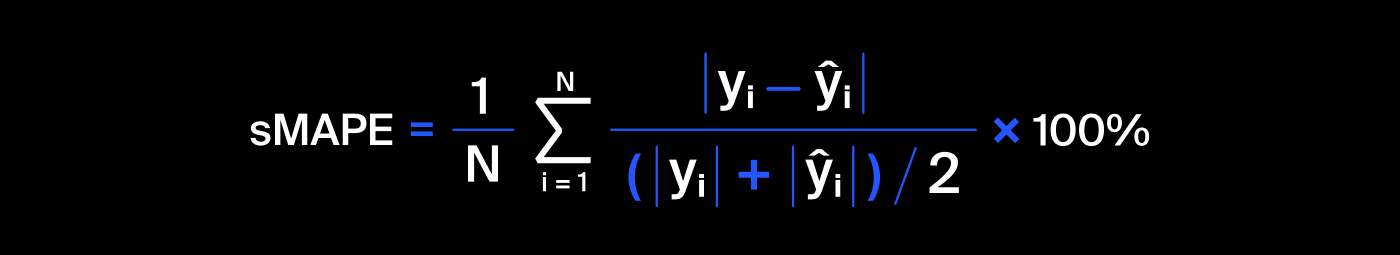

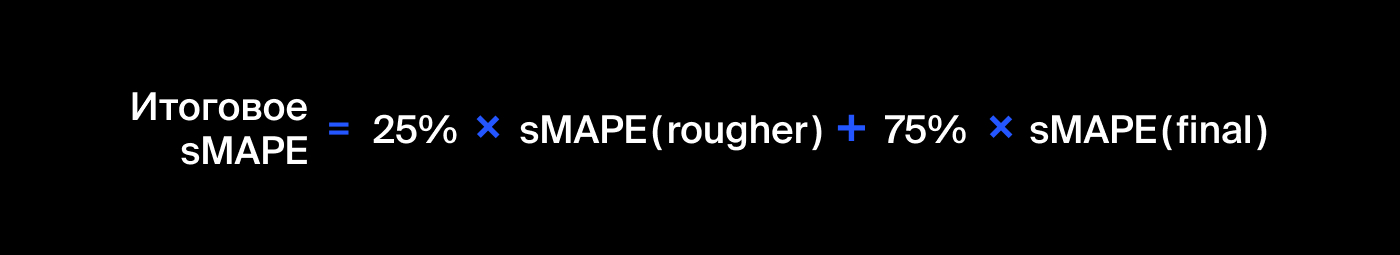

In [17]:
def smape(target, predicted):
    error = 100 * (abs(target - predicted) / 
             ((abs(target) + abs(predicted)) / 2)).mean()
    return .25 * error[0] + .75 * error[1]

Сразу создадим скорер для дальнейшей кросс-валидации:

In [18]:
smape_scorer = make_scorer(smape, greater_is_better=False)

### Обучение моделей

Подготовим данные к обучению. Разделим целевые и остальные признаки:

In [19]:
features_train = df[df['date'].isin(dates_train)] \
                    .drop(missing_features, axis=1) \
                    .drop('date', axis=1)
target_train = df[df['date'].isin(dates_train)][['rougher.output.recovery', 
                                                 'final.output.recovery']]
features_test = df[df['date'].isin(dates_test)] \
                    .drop(missing_features, axis=1) \
                    .drop('date', axis=1)
target_test = df[df['date'].isin(dates_test)][['rougher.output.recovery', 
                                               'final.output.recovery']]

Нормализуем признаки:

In [20]:
scaler = StandardScaler()
scaler.fit(features_train)

features_train_scaled = scaler.transform(features_train)
features_test_scaled = scaler.transform(features_test)

Обучим модели и оценим их качество кросс-валидацией.
<br>Случайный лес:

In [21]:
%%time
# для экономии времени сперва найдем оптимальную глубину, а затем число деревьев
for depth in range(1, 6):
    model = RandomForestRegressor(n_estimators=20, max_depth=depth, random_state=42)
    score = cross_val_score(
        model, features_train_scaled, target_train, scoring=smape_scorer).mean()
    print('Max_depth:', depth, '\tScore:', score)

Max_depth: 1 	Score: -9.10954005660283
Max_depth: 2 	Score: -9.116756029159635
Max_depth: 3 	Score: -8.80922509102025
Max_depth: 4 	Score: -8.95724254984301
Max_depth: 5 	Score: -9.376186788897973
CPU times: user 55.7 s, sys: 154 ms, total: 55.9 s
Wall time: 55.9 s


In [22]:
%%time
for est in range(10, 51, 10):
    model = RandomForestRegressor(n_estimators=est, max_depth=3, random_state=42)
    score = cross_val_score(
        model, features_train_scaled, target_train, scoring=smape_scorer).mean()
    print('Estimators:', est, '\tScore:', score)

Estimators: 10 	Score: -8.879535474077922
Estimators: 20 	Score: -8.80922509102025
Estimators: 30 	Score: -8.777982818310127
Estimators: 40 	Score: -8.79015445443618
Estimators: 50 	Score: -8.764894362993491
CPU times: user 1min 22s, sys: 191 ms, total: 1min 23s
Wall time: 1min 23s


Линейная регрессия:

In [23]:
model = LinearRegression()
score = cross_val_score(
        model, features_train_scaled, target_train, scoring=smape_scorer).mean()
print('Score:', score)

Score: -10.103896741353381


Лучший результат показала модель случайного леса с максимальной глубиной 3 и 50 деревьями, ее кросс-валидационный sMAPE равен -8.76.
<br>Применим полученную модель на тестовой выборке и сравним результат:

In [24]:
%%time
model = RandomForestRegressor(n_estimators=50, max_depth=3, random_state=42)
model.fit(features_train_scaled, target_train)
predicted = model.predict(features_test_scaled)
smape(target_test, predicted)

CPU times: user 6.92 s, sys: 71.9 ms, total: 6.99 s
Wall time: 7.08 s


7.232993763969147

### Проверка модели на вменяемость

Проверим нашу лучшую модель на вменяемость. Напишем функцию, которая будет сравнивать ошибки sMAPE разных типов dummy-моделей с ошибкой лучшей модели и возвращать разницу. Если значения положительны - наша модель лучше константной:

In [41]:
from sklearn.dummy import DummyRegressor

In [42]:
def sanity_check(strat, best_result):
    dummy = DummyRegressor(strategy=strat)
    dummy.fit(features_train_scaled, target_train)
    predicted_dummy = dummy.predict(features_test_scaled)
    
    return abs(smape(target_test, predicted_dummy)) - abs(best_result)

In [43]:
sanity_check('mean', 7.232993763969147)

0.5378313314838516

In [44]:
sanity_check('median', 7.232993763969147)

0.13659678275934173

Ошибка лучшей модели меньше, чем ошибка константной модели со средними и медианными значениями. Тест на вменяемость пройден.

## Выводы

### Результаты

Cоздан прототип модели машинного обучения, предсказывающей коэффициент восстановления золота из золотосодержащей руды. 
- Лучшая модель: RandomForestRegressor
- Параметры модели: n_estimators=50, max_depth=3
- Ошибка модели на тестовых данных (Final sMAPE): 7.23
- Модель прошла проверку на вменяемость

### Что можно улучшить

Заметно, что разность метрик качества (константной и нашей модели) -  не слишком большая (всего 0.14 или 2%). Заказчик допустил такое расхождение метрик, но для дальнейшего улучшения качества моделирования можно пересмотреть и углубить некоторые этапы анализа:
1. Качество данных на входе модели машинного обучения: повторно оценить аномалии, пропуски, соответствие законам химии и физики.
2. Features Engineering: возможно, стоит обратиться к технологу производства и ещё раз пробежаться по бизнес-цепочке процесса.
3. Отбор моделей: расширить круг проверяемых моделей, провести Grid Search гиперпараметров.